Testing the deflection angle grid using:
    1. Only MGE parametrization
    2. MGE light star parametrization + analytical mass model
    
For the analytical mass model we are using the spherical NFW. This choise is motivated by our previous parametrization of this profile. In this way, we can compare the results, once the same NFW model are used in both inversion.

In [2]:
import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck15 as cosmo

Grid with pixel position, in arcsec.

In [47]:
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.09, sub_size=1)

In [48]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)           #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SphNFW_2e3arcsec.txt", unpack=True)     #DM component


In [49]:
#Input
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 1.00                                                          #kappa_s of DM halo
r_s    = 11.5                                                          #scale radius os dm halo
ml     = 7.7                                                           #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

# Only MGE parametrization

In [50]:
#Initializing
mass_profile_MGE = al.mp.MGE()


#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm=kappa_*surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [51]:
%timeit mass_profile_MGE.deflections_from_grid(grid)

3.47 s ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Both profiles

In [52]:
#Initializing
mass_profile_BOTH = al.mp.MGE()

#Analytical DM
sNFW = al.mp.dark_mass_profiles.SphericalNFW(kappa_s=kappa_, scale_radius=r_s)                

#Components of MGE, only stars
mass_profile_BOTH.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh)

#Including analytic model for DM
mass_profile_BOTH.Analytic_Model(analytic_profile=sNFW)

In [53]:
%timeit mass_profile_BOTH.deflections_from_grid(grid)

2.65 s ± 7.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Ploting result

In [10]:
result_MGE  = mass_profile_MGE.deflections_from_grid(grid)
result_BOTH = mass_profile_BOTH.deflections_from_grid(grid)

Text(0, 0.5, 'Residual')

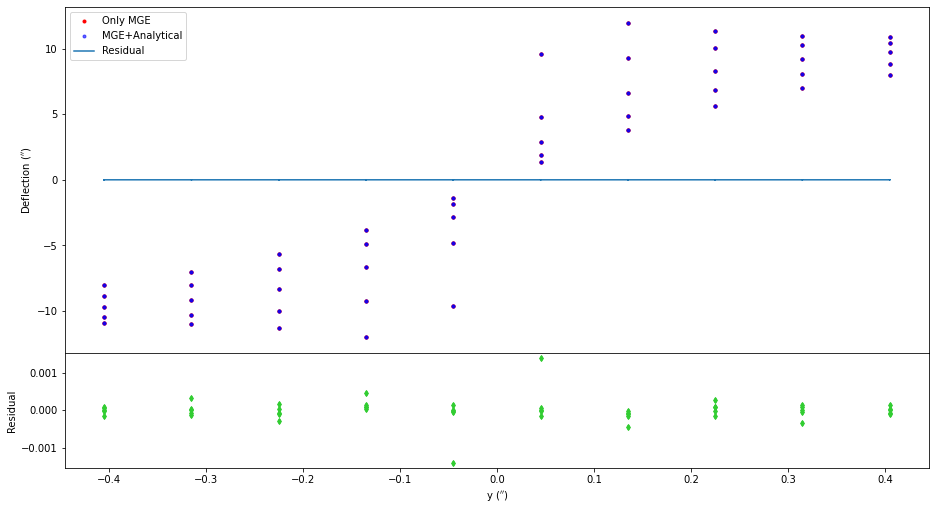

In [43]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,0],result_MGE[:,0], ".r", label="Only MGE")
plt.plot(grid[:,0],result_BOTH[:,0], ".b", label="MGE+Analytical", alpha=0.6)
plt.plot(grid[:,0],result_MGE[:,0]-result_BOTH[:,0], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,0],result_MGE[:,0]-result_BOTH[:,0],'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("Residual")

Text(0, 0.5, 'Residual')

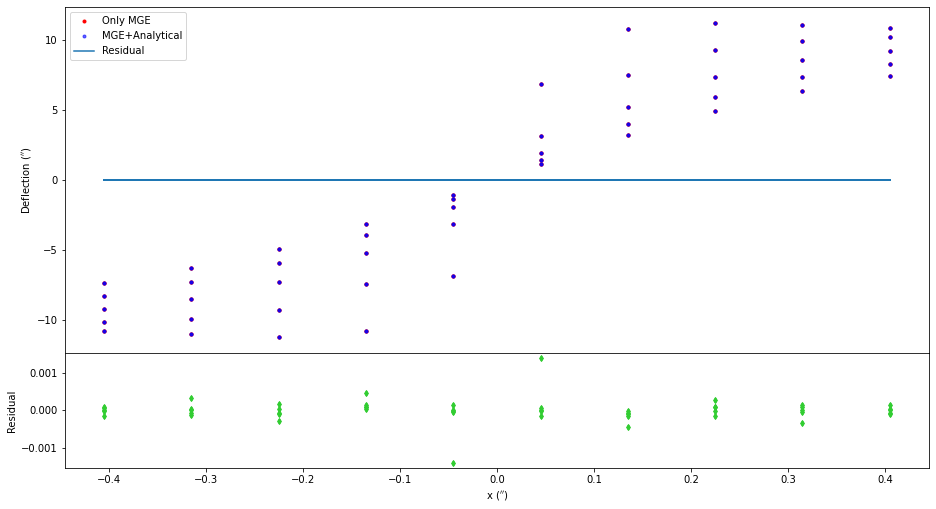

In [44]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,1],result_MGE[:,1], ".r", label="Only MGE")
plt.plot(grid[:,1],result_BOTH[:,1], ".b", label="MGE+Analytical", alpha=0.6)
plt.plot(grid[:,1],result_MGE[:,1]-result_BOTH[:,1], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,1],result_MGE[:,1]-result_BOTH[:,1],'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("x ($''$)")
plt.ylabel("Residual")